# Practice 1: Evasion against Image classifier 
- Task 1: Untargeted attack against an image
- Task 2: Targeted attack against an image

In [6]:
from PIL import Image
from torchvision import transforms
from IPython.display import display
import matplotlib.pyplot as plt


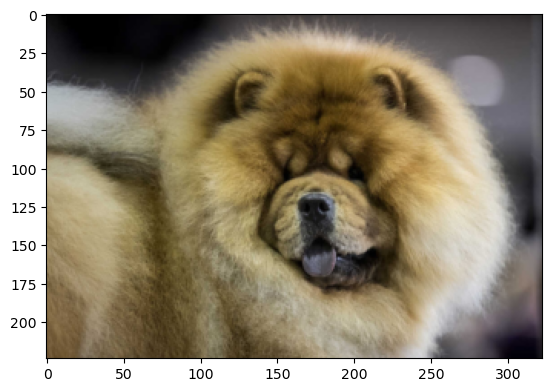

In [7]:
# read the image, resize to 224 and convert to PyTorch Tensor
img = Image.open("dog.jpg")

preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
dog_tensor = preprocess(img)[None,:,:,:]

# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(dog_tensor[0].numpy().transpose(1,2,0))
 

# Load torchvision models

In [9]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

# Create normalization module
the weird indexing here is just used to comply with PyTorch standards that all inputs to modules should be of the form batch_size x num_channels x height x width).

In [10]:
# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]
    
# values are standard normalization for ImageNet images,
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Load pre-trained ResNet50

In [11]:
# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = resnet50(pretrained=True)
model.eval()


/Users/acs/miniforge/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/acs/miniforge/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Predict our test sample

In [28]:
# predict the loaded image
pred = model(norm(dog_tensor))
print(pred.shape)
# print probabilites

# load json file
import json
with open('imagenet_class_index.json') as f:
    id2obj = {int(k):v[1] for k, v in json.load(f).items()}
# invert the dictionary
obj2id = {v:k for k,v in id2obj.items()}

print (id2obj)
print (obj2id)

# get the index of the maximum value
pred_idx = torch.argmax(pred).item()
print ("Predicted class:", id2obj[pred_idx])
# print confidence of prediction
print ("Confidence:", torch.nn.Softmax()(pred)[0,pred_idx].item())

#print (pred.shape)
#print (torch.nn.Softmax()(pred[0]))

torch.Size([1, 1000])
{0: 'tench', 1: 'goldfish', 2: 'great_white_shark', 3: 'tiger_shark', 4: 'hammerhead', 5: 'electric_ray', 6: 'stingray', 7: 'cock', 8: 'hen', 9: 'ostrich', 10: 'brambling', 11: 'goldfinch', 12: 'house_finch', 13: 'junco', 14: 'indigo_bunting', 15: 'robin', 16: 'bulbul', 17: 'jay', 18: 'magpie', 19: 'chickadee', 20: 'water_ouzel', 21: 'kite', 22: 'bald_eagle', 23: 'vulture', 24: 'great_grey_owl', 25: 'European_fire_salamander', 26: 'common_newt', 27: 'eft', 28: 'spotted_salamander', 29: 'axolotl', 30: 'bullfrog', 31: 'tree_frog', 32: 'tailed_frog', 33: 'loggerhead', 34: 'leatherback_turtle', 35: 'mud_turtle', 36: 'terrapin', 37: 'box_turtle', 38: 'banded_gecko', 39: 'common_iguana', 40: 'American_chameleon', 41: 'whiptail', 42: 'agama', 43: 'frilled_lizard', 44: 'alligator_lizard', 45: 'Gila_monster', 46: 'green_lizard', 47: 'African_chameleon', 48: 'Komodo_dragon', 49: 'African_crocodile', 50: 'American_alligator', 51: 'triceratops', 52: 'thunder_snake', 53: 'ring

/var/folders/gc/zsvk_1js3s5fv9k8qwfry1dr0000gn/T/ipykernel_61017/1036382287.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print ("Confidence:", torch.nn.Softmax()(pred)[0,pred_idx].item())


# PGD attack (white-box)

In [30]:
import torch.optim as optim

## Task 1: Untargeted (maximize the loss)
Let $\delta$ be the perturbation that we want to compute. Maximize the loss with respect to the original class $y_{orig}$ such that $||\delta||_{\infty} \leq \varepsilon$. Compute $\delta$ with PGD iteratively:
$$ \delta_t = Clip_{(-\varepsilon, \varepsilon)}(\delta_{t-1} + \eta \cdot sign(\nabla_\delta loss_f(\theta, x+\delta_{t-1}, y_{orig})))$$


In [33]:
# create a random image (gray) with the same size as the dog image
delta = torch.zeros_like(dog_tensor, requires_grad=True)

# maximum perturbation
eps = 2/255.0

# create opt (SGD)
opt = optim.SGD([delta], lr=1)

# SGD iterations (30)
for t in range(30):
    # forward pass (predict with noise image, and normalize the image with mean and std of ImageNet)
    pred = model(norm(dog_tensor + delta))

    # maximize the loss of original class (give long tensor as target class), we have to take the negative sign to enfore the maximization
    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([pred_idx]))
    
    # print loss and show image every 5 iterations
    if t % 5 == 0:
        print(t, loss.item())
       
    # zero all existing gradients
    opt.zero_grad()

    # backward pass
    loss.backward()

    # take the sign of the gradient
    delta.grad.sign_()
    delta.grad.data *= 0.01

    # update the noise
    opt.step()

    # projection with clipping
    delta.data.clamp_(-eps, eps)
 

0 -0.06442513316869736
5 -13.868202209472656
10 -22.945615768432617
15 -23.51305389404297
20 -26.407005310058594
25 -23.60686492919922


In [36]:
# Check new prediction and confidence scores
pred = model(norm(dog_tensor + delta))
pred_idx_adv = torch.argmax(pred).item()
print ("Predicted class:", id2obj[pred_idx_adv])
# print confidence of prediction
print ("Confidence:", torch.nn.Softmax()(pred)[0,pred_idx_adv].item())
# print confidence of original prediction
print ("Confidence original:", torch.nn.Softmax()(pred)[0,pred_idx].item())

Predicted class: colobus
Confidence: 0.9925526976585388
Confidence original: 9.180851608461826e-13


/var/folders/gc/zsvk_1js3s5fv9k8qwfry1dr0000gn/T/ipykernel_61017/514631327.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print ("Confidence:", torch.nn.Softmax()(pred)[0,pred_idx_adv].item())
/var/folders/gc/zsvk_1js3s5fv9k8qwfry1dr0000gn/T/ipykernel_61017/514631327.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print ("Confidence original:", torch.nn.Softmax()(pred)[0,pred_idx].item())


# Show original image and perturbed image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


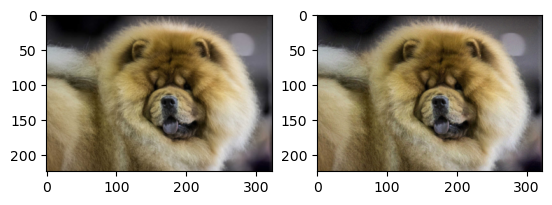

In [59]:
# Let's see the result

# display images
fig, ax = plt.subplots(1,2)

# noisy image (detach the tensor and convert to numpy then transpose CHW to HWC)
ax[0].imshow(dog_tensor[0].numpy().transpose(1,2,0))
ax[1].imshow((dog_tensor+delta)[0].detach().numpy().transpose(1,2,0))

# display noise
#plt.imshow((delta*100)[0].detach().numpy().transpose(1,2,0))

# Task 2: Targeted attack
## PGD (Projected Gradient Descent):
Let $\delta$ be the perturbation that we want to compute. Minimize the loss with respect to the target class $y_{target}$ such that $||\delta||_{\infty} \leq \varepsilon$. Compute $\delta$ with PGD iteratively:
$$ \delta_t = Clip_{(-\varepsilon, \varepsilon)}(\delta_{t-1} - \eta \cdot sign(\nabla_\delta loss_f(\theta, x+\delta_{t-1}, y_{target})))$$

In [60]:
# Targeted attack (do to a toaster)
target_idx = obj2id["toaster"]
print ("Target class id:", target_idx)

Target class id: 859


In [48]:
# misclassify as toaster

# create a random image (gray) with the same size as the dog image
delta = torch.zeros_like(dog_tensor, requires_grad=True)

# maximum perturbation
eps = 2/255.0

# create opt (SGD)
opt = optim.SGD([delta], lr=1)

# SGD iterations (30)
for t in range(30):
    # forward pass (predict with noise image, and normalize the image with mean and std of ImageNet)
    pred = model(norm(dog_tensor + delta))

    # minimize the loss of target class (give long tensor as target class) and maximize the loss of original class
    loss = nn.CrossEntropyLoss()(pred, torch.LongTensor([target_idx])) - nn.CrossEntropyLoss()(pred, torch.LongTensor([pred_idx])) 
    
    # print loss and show image every 5 iterations
    if t % 5 == 0:
        print(t, loss.item())
       
    # zero all existing gradients
    opt.zero_grad()

    # backward pass
    loss.backward()

    # take the sign of the gradient
    delta.grad.sign_()
    delta.grad.data *= 0.01

    # update the noise
    opt.step()

    # projection with clipping
    delta.data.clamp_(-eps, eps)
 

0 12.01498794555664
5 -10.07784366607666
10 -9.79640007019043
15 -13.032638549804688
20 -10.761306762695312
25 -14.41403579711914


In [49]:
# print prediction and confidence
# Check new prediction and confidence scores
pred = model(norm(dog_tensor + delta))
pred_idx_adv = torch.argmax(pred).item()
print ("Predicted class:", id2obj[pred_idx_adv])
# print confidence of prediction
print ("Confidence:", torch.nn.Softmax()(pred)[0,pred_idx_adv].item())
# print confidence of original prediction
print ("Confidence original:", torch.nn.Softmax()(pred)[0,pred_idx].item())

Predicted class: toaster
Confidence: 0.9920752048492432
Confidence original: 1.5036808918011957e-06


/var/folders/gc/zsvk_1js3s5fv9k8qwfry1dr0000gn/T/ipykernel_61017/102419881.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print ("Confidence:", torch.nn.Softmax()(pred)[0,pred_idx_adv].item())
/var/folders/gc/zsvk_1js3s5fv9k8qwfry1dr0000gn/T/ipykernel_61017/102419881.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print ("Confidence original:", torch.nn.Softmax()(pred)[0,pred_idx].item())


## How the noise looks like?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


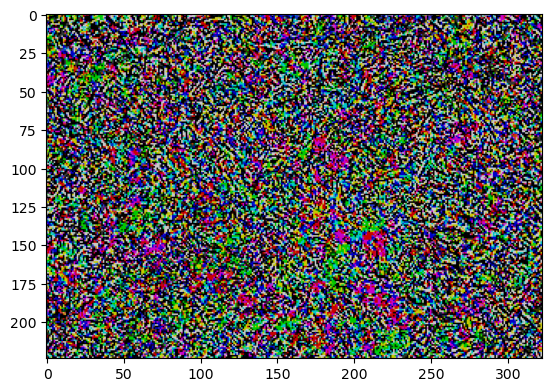

In [53]:
# display noise (scale the noise to be visible)
# Let's see the result

# original image (detach the tensor and convert to numpy then transpose CHW to HWC)
#plt.imshow(dog_tensor[0].numpy().transpose(1,2,0))

# noisy image (detach the tensor and convert to numpy then transpose CHW to HWC)
#plt.imshow((dog_tensor + delta)[0].detach().numpy().transpose(1,2,0))

# display noise
plt.imshow((delta*100)[0].detach().numpy().transpose(1,2,0))